Import Libaries

In [133]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import tensorflow as tf

Optiimize GPU memory Utilization

In [134]:
### Limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
print('Available Physical GPUs=>'+str(gpus))
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print('Configured Logical GPUs=>'+str(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Available Physical GPUs=>[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical devices cannot be modified after being initialized


Define Custom environment for VPP charging/ discharging scheduling

In [89]:
class VPP(Env):
    def __init__(self):
        #Environment parameters
        self.state = random.randint(0, 100)  #current soc
        self.max_soc = 95
        self.min_soc = 15
        self.generation = random.randint(0, 100)
        self.demand = random.randint(5, 75)

        #Action space (charge, discharge, isolate)
        self.action_space = Discrete(3)

        #State_space
        self.observation_space = Box(low = np.array([0]), high = np.array([100]))

        #Set episode length
        self.episode_length = 900


    #Define steps based on action
    def step(self, action):
        if action == 0:    #charge
            self.state = self.state+1
        elif action == 1:   #discharge
            self.state = self.state-1
        # Action 2 : Isolate (no effect on SoC)

        self.episode_length -= 1

    
        #Define the reward based on generation, demand, and current soc level
        if (self.generation > self.demand) & self.state>=self.min_soc & self.state<=self.max_soc:
            reward = 1.0
        else:
            reward = -1.0

        #Check if the episode is done
        if self.episode_length<=0:
            done = True
        else:
            done = False

        info = {}

        return self.state, reward, done, info
    
    def render(self):
        pass

    def reset(self):
        self.state = random.randint(0, 100)
        self.episode_length = 900
        return self.state

Calling the VPP environment

In [90]:
env = VPP()

In [91]:
#Random action in each step
print(env.action_space.sample())

#dimention of state
print(env.observation_space.shape[0])

#Random initial temp
print(env.state)

2
1
8


In [92]:
action = env.action_space.sample()
state, reward, done, info = env.step(action)
print(state, reward, done, info)

8 -1.0 False {}


In [122]:
ep = []
scr = []
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        score += reward
    ep.append(int(episode))
    scr.append(score)
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-86.0
Episode:2 Score:-62.0
Episode:3 Score:-94.0
Episode:4 Score:-82.0
Episode:5 Score:-100.0
Episode:6 Score:-86.0
Episode:7 Score:-98.0
Episode:8 Score:-36.0
Episode:9 Score:-94.0
Episode:10 Score:-76.0


Visualization

Text(0, 0.5, 'Score')

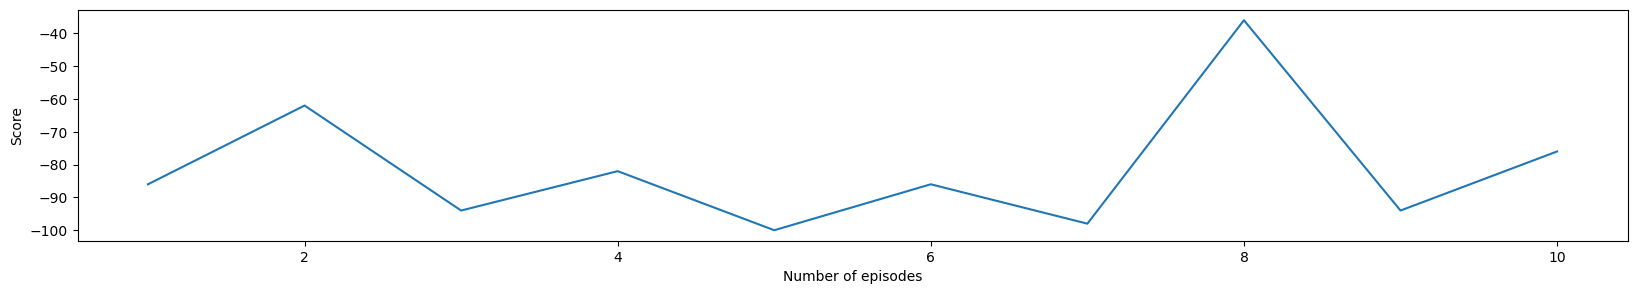

In [136]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,3))

plt.plot(ep, scr)
plt.xlabel('Number of episodes')
plt.ylabel('Score')

Import libraries for DQN

In [95]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [96]:
states = env.observation_space.shape
actions = env.action_space.n

In [97]:
print(states, actions)

(1,) 3


Build Model free DQN

In [98]:
def build_model(states,actions):
    model = Sequential()
    model.add(Dense(24, activation = 'relu', input_shape = states))
    model.add(Dense(24, activation = 'relu'))
    model.add(Dense(actions, activation = 'linear'))
    return model

In [104]:
del model

In [106]:
model = build_model(states, actions)

In [107]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 24)                48        
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 3)                 75        
                                                                 
Total params: 723
Trainable params: 723
Non-trainable params: 0
_________________________________________________________________


Import Libraries for DQN Agent

In [108]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

Building the DQN Agent

In [109]:
def  build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit = 50000, window_length = 1)
    dqn = DQNAgent(model = model, memory = memory, policy = policy,
                   nb_actions = actions, nb_steps_warmup = 10, target_model_update = 1e-2)
    return dqn

Training the model free DQN Agent for VPP environment

In [110]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr = 1e-3), metrics = ['mae'])
dqn.fit(env, nb_steps = 50000, visualize = False,  verbose = 1)

Training for 50000 steps ...
Interval 1 (0 steps performed)


c:\Users\Arbil\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    1/10000 [..............................] - ETA: 2:19:49 - reward: -1.0000

c:\Users\Arbil\anaconda3\envs\py37gpu\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 62s 6ms/step - reward: -0.4662
100 episodes - episode_reward: -46.620 [-100.000, 86.000] - loss: 1.398 - mae: 9.364 - mean_q: -7.346

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: -0.3306
100 episodes - episode_reward: -33.060 [-96.000, 92.000] - loss: 3.587 - mae: 14.286 - mean_q: 1.735

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 127s 13ms/step - reward: -0.2840
100 episodes - episode_reward: -28.400 [-100.000, 92.000] - loss: 4.079 - mae: 14.764 - mean_q: 6.204

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -0.2388
100 episodes - episode_reward: -23.880 [-100.000, 90.000] - loss: 4.523 - mae: 15.743 - mean_q: 8.188

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 61s 6ms/step - reward: -0.2674
done, took 453.003 seconds


Evaluating the model free DQN 

In [111]:
scores = dqn.test(env, nb_episodes = 100, visualize = False)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: -26.000, steps: 100
Episode 2: reward: 94.000, steps: 100
Episode 3: reward: 36.000, steps: 100
Episode 4: reward: 36.000, steps: 100
Episode 5: reward: -62.000, steps: 100
Episode 6: reward: -36.000, steps: 100
Episode 7: reward: 64.000, steps: 100
Episode 8: reward: 26.000, steps: 100
Episode 9: reward: -18.000, steps: 100
Episode 10: reward: 6.000, steps: 100
Episode 11: reward: -68.000, steps: 100
Episode 12: reward: 60.000, steps: 100
Episode 13: reward: 78.000, steps: 100
Episode 14: reward: 16.000, steps: 100
Episode 15: reward: -72.000, steps: 100
Episode 16: reward: -18.000, steps: 100
Episode 17: reward: -50.000, steps: 100
Episode 18: reward: -36.000, steps: 100
Episode 19: reward: 100.000, steps: 100
Episode 20: reward: 18.000, steps: 100
Episode 21: reward: -72.000, steps: 100
Episode 22: reward: -20.000, steps: 100
Episode 23: reward: -64.000, steps: 100
Episode 24: reward: -30.000, steps: 100
Episode 25: reward: 24.000, ste

Text(0, 0.5, 'Reward')

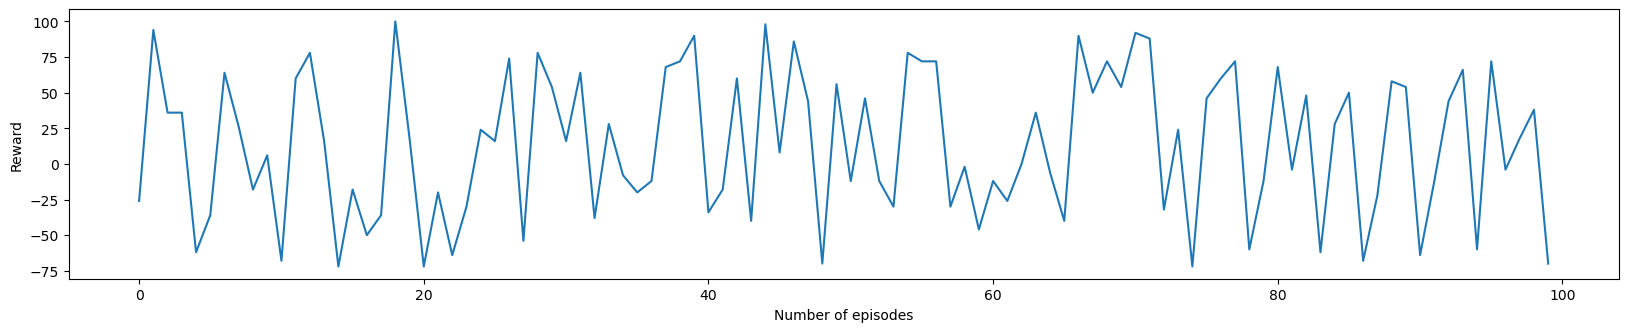

In [137]:
plt.figure(figsize = (20,3.5))
plt.plot(scores.history['episode_reward'])
plt.xlabel('Number of episodes')
plt.ylabel('Reward')